# BART: Bayesian Additive Regression Trees

> **BART 개요**
- 트리의 합으로 f(x) = E(Y|x) 근사
- 트리에 대해 prior을 둬서 regularization
- Bayesian backfitting MCMC 로 fitting
: iteratively construct and fit successive residuals  
> 
- prior를 사용하여 모수가 많은 모델을 추정하는 Bayesian nonparametric approach로 볼 수 있음  
- 각각의 트리는 f의 서로 다른 부분을 조금씩 설명하게 됨    
(개별적인 트리의 posterior averaging과는 차이를 보임)

$Y=g(x;T_1,M_1)+g(x;T_2,M_2)+...+g(x;T_m,M_m)+ \sigma z,~~z~follows~N(0,1)$  
- 트리의 합으로 f(x) = E(Y|x) 근사

$\pi(\theta)=\pi((T_1,M_1),(T_2,M_2),...,(T_m,M_m),\sigma)$  
- $\pi~~wants:~~T,\mu~~small,~nice~~\sigma$ 
- 트리에 $\pi$ 라는 prior을 둬서 regularization  
(각 g의 기여를 적게 함)

$Y=g(x;T_1,M_1)+g(x;T_2,M_2)+...+g(x;T_m,M_m)+ \sigma z$  
$~~~plus~~\pi((T_1,M_1),(T_2,M_2),...,(T_m,M_m),\sigma)$  
- MCMC 로 모수 업데이트

> 각 모델 iteration마다 특정 변수의 등장 빈도를 계산하여 어떤 성분이 Y를 잘 설명하는지 알 수 있다.  
> 예측을 위해서는 m을 크게, 변수 선택을 위해서는 m을 작게 설정하도록 한다.

> **Nice things about BART/PBART**: 
- don’t have to think about x’s (compare: add x2 j and use lasso). 
- don’t have to prespecify level of interaction (compare: boosting in R)
- competitive out-of-sample.
- stable MCMC. 
- stochastic search. 
- simple prior. 
- uncertainty. 
- small p and big n

#1. 데이터 가져오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd

os.chdir('/content/drive/MyDrive/Bigcam')

In [ ]:
train = pd.read_csv("train_data.csv")
test = pd.read_csv("test_data.csv")

In [ ]:
train.head()

,is_applied,loan_limit,loan_rate,loan_limit_100million,CompleteIDCertification,EndLoanApply,credit_score,yearly_income,income_type,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt,birth_year,gender,company_time
0,0,24000000.0,17.1,False,2,1,640.0,28000000.0,EARNEDINCOME,정규직,기타가족소유,5000000.0,생활비,0,0,6,35000000.0,1988,1,36
1,0,14000000.0,20.0,False,1,7,700.0,30000000.0,FREELANCER,기타,전월세,15000000.0,전월세보증금,0,1,1,10000000.0,1990,0,0
2,0,12000000.0,13.9,False,3,4,960.0,45000000.0,EARNEDINCOME,정규직,기타가족소유,20000000.0,생활비,0,1,2,39000000.0,1975,1,51
3,0,53000000.0,12.6,False,0,2,890.0,50000000.0,EARNEDINCOME,정규직,전월세,50000000.0,생활비,0,1,3,33000000.0,1981,1,36
4,0,10000000.0,14.3,False,24,78,630.0,55000000.0,EARNEDINCOME,정규직,전월세,50000000.0,생활비,0,1,1,51000000.0,1977,1,9


# 2. Bart

In [ ]:
!pip3 install git+https://github.com/JakeColtman/bartpy.git --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/JakeColtman/bartpy.git to /tmp/pip-req-build-gzdojkqj
  Running command git clone -q https://github.com/JakeColtman/bartpy.git /tmp/pip-req-build-gzdojkqj


In [ ]:
from bartpy.sklearnmodel import SklearnModel
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

X_train = train.drop('is_applied', axis = 1)
y_train = train['is_applied']
X_test = test.drop('is_applied', axis = 1)
y_test = test['is_applied']

> **Parameters**:	
- n_trees (int) – the number of trees to use, more trees will make a smoother fit, but slow training and fitting
- sigma_a (float) – shape parameter of the prior on sigma
- sigma_b (float) – scale parameter of the prior on sigma
- n_samples (int) – how many recorded samples to take
- n_burn (int) – how many samples to run without recording to reach convergence
- p_grow (float) – probability of choosing a grow mutation in tree mutation sampling
- p_prune (float) – probability of choosing a prune mutation in tree mutation sampling
- alpha (float) – prior parameter on tree structure
- beta (float) – prior parameter on tree structure

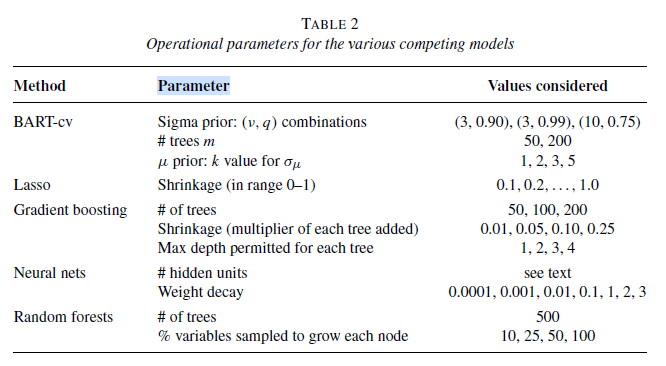

In [ ]:
bart = SklearnModel(n_samples = 500, n_burn = 500, n_chains = 1)
parameters = {'n_trees': [50, 100]}

In [ ]:
grid_search = GridSearchCV(bart, parameters, cv = 3, scoring = 'f1_micro')
grid_search.fit(X_train,y_train)
print(grid_search.best_params_)

In [ ]:
best_bart = SklearnModel(n_samples = 100, n_burn = 100, n_chains = 1, n_jobs = 1, n_trees = 50)
best_bart.fit(X_train,y_train)
prediction = best_bart.predict(X_test)
report = classification_report(y_test,prediction)
print(report)